In [1]:
import os, math
import numpy as np
import pandas as pd
import seaborn as sns
import helpers

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
y = pd.read_csv('./data/training_variants')
X = pd.read_csv('./data/training_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
text_train, text_test, variants_train, variants_test = train_test_split(X, y, test_size=0.2, \
                                                                        random_state=0, stratify=None)

train_full = variants_train.merge(text_train, how='inner', on='ID')
test_full = variants_test.merge(text_test, how='inner', on='ID')

print(train_full.shape)
print(test_full.shape)

(2656, 5)
(665, 5)


Use TF-IDF to Vectorize the texts. 

In [3]:
tfidf = TfidfVectorizer(
    min_df=1, max_features=16000, strip_accents='unicode',lowercase =True,
    analyzer='word', use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english').fit(train_full["Text"])

Xtr_train = tfidf.fit_transform(train_full["Text"])
Xtr_test = tfidf.fit_transform(test_full["Text"])
features = tfidf.get_feature_names()

To get some feeling of what's in the texts.

In [4]:
row = np.squeeze(Xtr_train[4].toarray())
top_id = np.argsort(row)[-100:]
for i in top_id:
    print(row[i])
    print(features[i])

0.0351466536324
e1644g
0.0351716786441
amygdala
0.0352190192372
aneuploidy
0.0352190192372
266
0.0356926293212
originates
0.0357652875216
attenuated
0.0358594728786
bortezomib
0.0361287955574
kilodalton
0.0362529108795
fev
0.0365659366494
play
0.0367047758165
i1170
0.0367850750969
golga4
0.0370190216448
kyse520
0.0371662302243
ready
0.0372431338601
147
0.0372904746582
tubule
0.0374545908243
single
0.0377647737775
hmec
0.0382543928408
craf
0.0383304483598
rcsb
0.0383304483598
unstimulated
0.0386798161818
caliper
0.0387181772803
g370c
0.0387732730168
categorical
0.0389570483337
p1675l
0.0389657941004
isomerase
0.0390652508031
sonication
0.0394370795833
rehydrated
0.0395072168774
parry
0.0396085057078
formation
0.039696038051
ranked
0.0397662995974
i2500f
0.0400747785632
directly
0.0401107824147
amy
0.0401966466217
tubulin
0.0402248654372
periodic
0.0406597800294
stored
0.0406840988674
figure2c
0.0409137104729
kwon
0.0409181251076
audrey
0.0416223165525
allele
0.0418844817079
carcinosarco

Use Rocchio(NearestCentroid) classification. 

In [5]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

y_train = train_full["Class"]
y_test = test_full["Class"]
clf = NearestCentroid()
clf.fit(Xtr_train, y_train)
print(clf.score(Xtr_test, y_test))
print(clf.get_params())
y_test_pred = clf.predict(Xtr_test)


0.231578947368
{'metric': 'euclidean', 'shrink_threshold': None}


Confusion matrix, without normalization
[[78 10  0 15  0  0  0  0  0]
 [56 20  0 16  0  0  0  0  0]
 [ 9  5  0 10  0  0  0  0  0]
 [73 15  0 56  0  0  0  0  0]
 [28  6  0 26  0  0  0  0  0]
 [33  5  0 13  0  0  0  0  0]
 [83 47  0 53  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0]
 [ 2  2  0  2  0  0  0  0  0]]


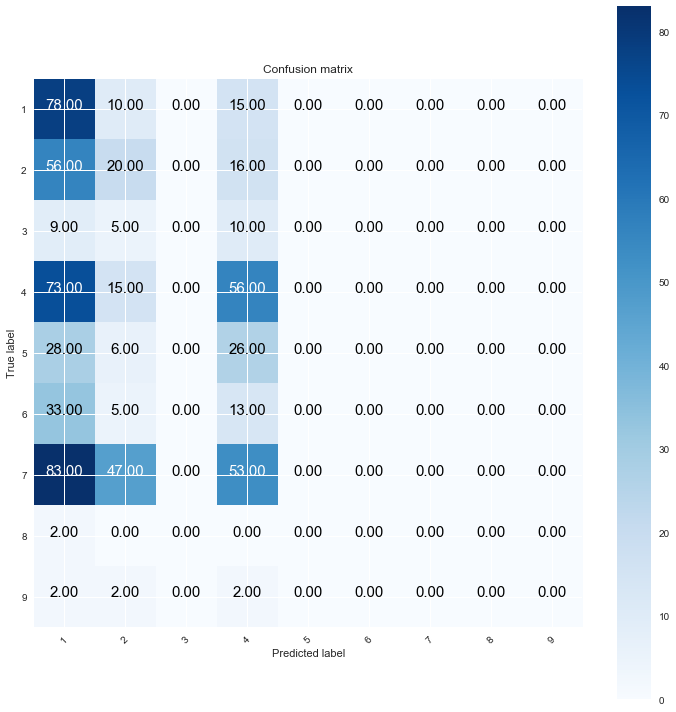

In [16]:
# Plot non-normalized confusion matrix
helpers.plot_confusion_matrix(y_test, y_test_pred, classes=range(1,10), normalize=False)

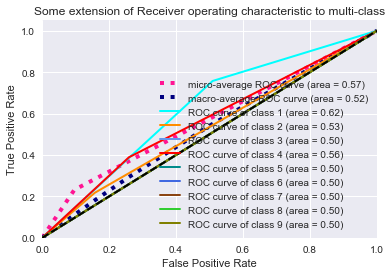

In [7]:
from sklearn.preprocessing import label_binarize

y_test_bi = label_binarize(y_test, classes=range(1, 10))
y_test_pred_bi = label_binarize(y_test_pred, classes=range(1, 10))
helpers.plot_roc_curve(y_test_bi, y_test_pred_bi)

log_loss makes more sense for probability prediction

In [21]:
from sklearn.metrics import log_loss
log_loss(y_test, y_test_pred_bi, eps=1e-15, normalize=True, labels=range(1, 10))

26.54032291398401